Experiments and Plotting 
-----------

In [1]:
""" Functions """

import numpy as np
import math
import matplotlib.pyplot as plt

from GridWorld import GridWorld
from Agent import Agent
from DQNAgent import DQNAgent
from IQLearnAgent import IQLearnAgent
from HumanAgent import HumanAgent
from Orchestrator import Orchestrator
from utils import *

def unroll_grid(state):
    if torch.is_tensor(state):
        state = state.numpy()
    w, h = state.shape
    
    s = state.reshape((1, w*h )) + \
        np.random.rand(1, w*h)/10.0 
    s = torch.from_numpy(s).float() 
    return s

def init_grid_model(input_size, action_space):
    """ provides an default model for the gridworld problem """
    l1 = input_size
    l2 = 150
    l3 = 100
    l4 = len(action_space)

    model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3,l4)
    )

    return model

def get_DQN_params(name='DQN', gamma=0.9, epsilon=1.0, epsilon_decay=0.97, epsilon_floor=0.1, training=True, training_freq=4, batch_size=32, buffer_max_size=512):
    
    """ creates a dictionary of parameters for training a DQNAgent """
    
    return {"name":name, 
            "agent_type":"DQN", 
            "gamma":gamma, 
            "epsilon":epsilon, 
            "epsilon_decay":epsilon_decay,
            "epsilon_floor":epsilon_floor, 
            "training":training, 
            "training_freq":training_freq, 
            "batch_size":batch_size, 
            "buffer_max_size":buffer_max_size}

def get_IQ_params(name='IQLearn', gamma=0.9, epsilon=1.0, epsilon_decay=0.97, epsilon_floor=0.1, training=True, training_freq=4, batch_size=32, num_trajectories=50, buffer_max_size=512, expert_data_path="expert_data/expert_DQN_20000.pkl"): # 'expert_data/good_dqn_2000.pkl'
    
    """ creates a dictionary of parameters for training an IQLearnAgent """
    return {"name":name, 
            "agent_type":"IQLearn", 
            "gamma":gamma, 
            "epsilon":epsilon, 
            "epsilon_decay":epsilon_decay,
            "epsilon_floor":epsilon_floor, 
            "training":training, 
            "training_freq":training_freq, 
            "batch_size":batch_size, 
            "num_trajectories":num_trajectories,
            "buffer_max_size":buffer_max_size,
            "expert_data_path":expert_data_path}

def get_agent_params(agent_type):
    """ gets a dictionary of parameters based on agent type that can be used by create_agent()"""
    if agent_type == "DQN":
        params = get_DQN_params()
    elif agent_type == "IQLearn":
        params = get_IQ_params()
    else:
        raise NotImplementedError(f"agent_type {agent_type} is not implemented. Only accepts 'DQN' or 'IQLearn'")
    return params

def create_agent(params, model, grid):
    if params['agent_type'] == "DQN":
        buffer = Buffer(memory_size=params["buffer_max_size"])
        agent = DQNAgent(model=model, action_space=grid.action_space, 
                         batch_size=params['batch_size'], 
                         name=params['name'],
                         gamma=params['gamma'],
                         epsilon=params['epsilon'],
                         epsilon_decay=params['epsilon_decay'],
                         epsilon_floor=params['epsilon_floor'],
                         training=params['training'],
                         training_freq=params['training_freq'])
        agent.buffer = buffer

    elif params['agent_type'] == "IQLearn":
        expert_buffer = Buffer(memory_size=params["buffer_max_size"])
        expert_buffer.load_trajectories(params['expert_data_path'], num_trajectories=params['num_trajectories'])
        agent = IQLearnAgent(model=model, action_space=grid.action_space, 
                         batch_size=params['batch_size'], 
                         name=params['name'],
                         gamma=params['gamma'],
                         epsilon=params['epsilon'],
                         epsilon_decay=params['epsilon_decay'],
                         epsilon_floor=params['epsilon_floor'],
                         training=params['training'],
                         training_freq=params['training_freq'])
        agent.set_expert_buffer(expert_buffer)
    else:
        raise NotImplementedError(f"agent_type {agent_type} is not implemented. Only accepts 'DQN' or 'IQLearn'")
    
    return agent

def train_agent(params, grid_shape=(10,10), num_timesteps=20000, testing_freq=50, num_test_games=24):
    """ train an agent over num_timesteps with a batch size of batch_size"""
    # create the gridworld game
    grid = GridWorld(width=grid_shape[0], height=grid_shape[1], random_start=True)

    # make the model
    model = Model(init_grid_model(grid.num_states, grid.action_space))
    model.format_state = unroll_grid

    # create the agent based on the agent_type
    agent = create_agent(params, model, grid)
    
    ## train and test
    num_training_blocks = math.floor(math.floor(num_timesteps / agent.training_freq) / testing_freq)
    timesteps_per_training_block = num_timesteps / num_training_blocks

    #print(f"num training blocks: {num_training_blocks}, timesteps per block: {timesteps_per_training_block}")

    # create an orchestrator to train the dqn_agent, which controls the game, with the game and agent objects
    orchestrator = Orchestrator(game=grid, agent=agent, num_timesteps=timesteps_per_training_block, until_game_limit=num_test_games, visualize=False)

    # testing dist_rats
    distance_ratios = {'mean_distance_ratios':[], 'std_distance_ratios':[]}

    # get value of current epsilon
    curr_epsilon = agent.epsilon

    for block in range(int(num_training_blocks)):

        # set up orchestrator for training 
        orchestrator.until_game = False

        # set up the agent for training
        agent.epsilon = curr_epsilon
        agent.epsilon_floor = params["epsilon_floor"]
        agent.training=True

        # perform training
        orchestrator.play()
        
        # update current epsilon
        curr_epsilon = agent.epsilon

        # set up the agent for testing
        agent.epsilon = 0.0
        agent.epsilon_floor = 0.0
        agent.training=False

        # set up orchestrator for testing
        orchestrator.until_game = True
        orchestrator.distance_ratios = []

        # perform testing
        print("------------------------")
        print(f"TESTING BLOCK: {block}...")
        orchestrator.play()

        # get the distance ratios and store average + std
        dist_rats = np.copy(orchestrator.distance_ratios)
        mean_dist_rat = np.mean(dist_rats)
        std_dist_rat = np.std(dist_rats)

        print(f"avg. distance ratio: {mean_dist_rat}, std: {std_dist_rat}")
        print("------------------------")

        distance_ratios['mean_distance_ratios'].append(mean_dist_rat)
        distance_ratios['std_distance_ratios'].append(std_dist_rat)

    # finish up training with remaining timesteps
    # print(f"num remaining steps: {num_timesteps % num_training_blocks}")
    orchestrator.until_game=False
    orchestrator.num_timesteps = num_timesteps % num_training_blocks
    orchestrator.play()
    
    # get model loss
    losses = model.loss_bucket

    return losses, distance_ratios

def plot_losses(losses, name="", folder_path="compare_training_results/", save=True):
    """ plot the losses for each model by timestep """
    # set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    # plot losses for each model
    for k in losses.keys():
        ax.plot(range(len(losses[k])), np.array(losses[k])/np.max(losses[k]))
        ax.set_xlabel('training steps')
        ax.set_ylabel('normalized loss')
    
    # create a figure legent
    ax.legend(losses.keys())

    # save the plot to an .svg
    if save:
        plt.tight_layout()
        fig.savefig(folder_path + "losses" + name + '.svg', format='svg', dpi=1200, bbox_inches='tight')
    
    # show the plot
    plt.show()

def plot_distance_ratios(dist_rats, name="", folder_path="compare_training_results/", save=True):
    """ plot the distance ratios for each model by game """
    # set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    # plot losses for each model
    for k in dist_rats.keys():
        x = range(len(dist_rats[k]["mean_distance_ratios"]))
        y = np.array(dist_rats[k]["mean_distance_ratios"])
        std_y = np.array(dist_rats[k]["std_distance_ratios"])
        ax.plot(x, y)
        ax.fill_between(x, y+std_y, y-std_y, alpha=0.3)
        ax.set_xlabel('testing blocks')
        ax.set_ylabel('distance ratio')
    
    # create a figure legend
    ax.legend(dist_rats.keys())

    # save the plot to an .svg
    if save:
        plt.tight_layout()
        fig.savefig(folder_path + "distance_ratios" + name + '.svg', format='svg', dpi=1200, bbox_inches='tight')
    
    # show the plot
    plt.show()

def IQ_compare_num_trajectories(num_trajectories:list):
    params = get_IQLearn_params()

    all_losses = {}
    all_dist_rats = {}

    for traj_count in num_trajectories:
        params['num_trajectories'] = traj_count
        losses, dist_rats = train_agent(params, grid_shape, num_timesteps)

        all_losses[batch_size] = losses
        all_dist_rats[batch_size] = dist_rats
    
    
    plot_losses(all_losses, name="_"+params['name']+"_batch_size_comparison")
    plot_distance_ratios(all_dist_rats, name="_"+params['name']+"_batch_size_comparison")

    return all_losses, all_dist_rats

def compare_batch_sizes(agent_type, batch_sizes, num_timesteps=20000, grid_shape=(10,10)):
    """ trains an agent using different batch sizes and plots the loss/timestep and 
        dist_rats/games """
    params = get_agent_params(agent_type)

    all_losses = {}
    all_dist_rats = {}

    for batch_size in batch_sizes:
        params['batch_size'] = batch_size
        losses, dist_rats = train_agent(params, grid_shape, num_timesteps)

        all_losses[batch_size] = losses
        all_dist_rats[batch_size] = dist_rats
    
    
    plot_losses(all_losses, name="_"+params['name']+"_batch_size_comparison")
    plot_distance_ratios(all_dist_rats, name="_"+params['name']+"_batch_size_comparison")

    return all_losses, all_dist_rats

def compare_param_range(agent_type, param_name, param_vals, num_timesteps=20000, grid_shape=(10,10)):
    """ trains an agent using different batch sizes and plots the loss/timestep and 
        dist_rats/games """
    params = get_agent_params(agent_type)

    all_losses = {}
    all_dist_rats = {}

    for val in param_vals:
        params[param_name] = val
        losses, dist_rats = train_agent(params, grid_shape, num_timesteps)

        all_losses[val] = losses
        all_dist_rats[val] = dist_rats
    
    
    plot_losses(all_losses, name="_"+params['name']+"_" +param_name+"_comparison")
    plot_distance_ratios(all_dist_rats, name="_"+params['name']+"_" +param_name+"_comparison")

    return all_losses, all_dist_rats

c:\Users\celin\Documents\python_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.3 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
### compare batch sizes for DQN
num_timesteps = 20000
losses, dist_rats = compare_param_range("DQN", "batch_size", [1, 4, 8, 32], num_timesteps=num_timesteps)
folder_path = "compare_training_results/"
losses_filepath = folder_path + f"losses_{num_timesteps}_batch_size_comparison.pkl"
with open(losses_filepath, 'wb') as file:
    pickle.dump(losses, file)

dist_rats_filepath = folder_path + f"distance_ratios_{num_timesteps}_batch_size_comparison.pkl"
with open(dist_rats_filepath, 'wb') as file:
    pickle.dump(dist_rats, file)

In [ ]:
### compare num_trajectories for IQLearn
num_timesteps = 20000
losses, dist_rats = compare_param_range("IQLearn", "num_trajectories", [25, 50, 100, 300], num_timesteps=num_timesteps)
folder_path = "compare_training_results/"
losses_filepath = folder_path + f"losses_{num_timesteps}_num_trajectories_comparison.pkl"
with open(losses_filepath, 'wb') as file:
    pickle.dump(losses, file)

dist_rats_filepath = folder_path + f"distance_ratios_{num_timesteps}_num_trajectories_comparison.pkl"
with open(dist_rats_filepath, 'wb') as file:
    pickle.dump(dist_rats, file)

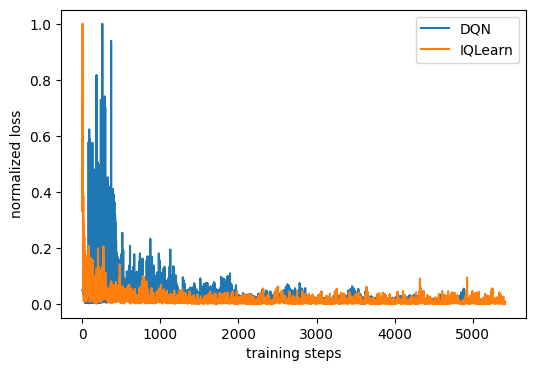

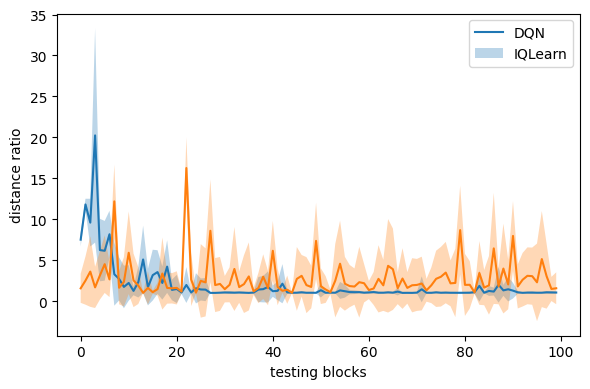

In [11]:
### compare between the two models

# loss comparison
with open("compare_training_results/losses_20000_batch_size_comparison.pkl", 'rb') as file:
    loss_DQN = pickle.load(file)
with open("compare_training_results/losses_20000_num_trajectories_comparison.pkl", 'rb') as file:
    loss_IQ = pickle.load(file)

# get loss data from the correct batch size
loss_DQN = loss_DQN[32]
# get loss data from the correct num trajectories
loss_IQ = loss_IQ[100]

plot_losses({"DQN":loss_DQN, "IQLearn":loss_IQ}, save=False)

# distance ratios comparison
with open("compare_training_results/distance_ratios_20000_batch_size_comparison.pkl", 'rb') as file:
    distance_ratios_DQN = pickle.load(file)
with open("compare_training_results/distance_ratios_20000_num_trajectories_comparison.pkl", 'rb') as file:
    distance_ratios_IQ = pickle.load(file)

# get distance ratios data from the correct batch size
distance_ratios_DQN = distance_ratios_DQN[32]
# get distance ratios data from the correct num trajectories
distance_ratios_IQ = distance_ratios_IQ[100]

plot_distance_ratios({"DQN": distance_ratios_DQN, "IQLearn":distance_ratios_IQ})